<a href="https://colab.research.google.com/github/faizanurrahman/temp_data/blob/master/ZS_Data_Science_H_Connect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problems Statement 
Health Care Connect, or H-Connect, is a Job search platform, which provides intelligent services to make the recruitment process batter for everyone. This time H-Connect wants to build a new feature in his platform that can help recruiters suggest a job type and job category based on the job description. 

In this challenge, H-Connect provides a Dataset that contains job description, job type, and job category based on this we have to build a model that predicts the job type and job category based on the job description. Let's dive into the dataset and make some useful insight.

### Data Understanding And Exploration

In [0]:
# import packages
import numpy as np
import pandas as pd
import spacy
import re

from gensim import corpora, models, similarities

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# setting up default plotting parameters
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})

sns.set_palette('viridis')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)


# ignore warnings
import warnings
warnings.filterwarnings('ignore')
np.random.seed(27)

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ZS Data Science/DataSet

In [0]:
# Read files.
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sample_submission = pd.read_csv('./sample_submission.csv')
# Size of Dataset's
print(f"Train Data Shape: {train.shape}")
print(f"\nTest Data Shape: {test.shape}")


In [0]:
 train.columns.values

array(['job_no', 'job_description', 'job_type', 'category', 'ngram_1',
       'ngram_2'], dtype=object)

**job_no -** A unique identifier for each job post.

**job_description -** The full text of the job post as provided by the job advertiser.

**job_type -** The type of job, full_time or part_time, permanent or contract, Seasonal or Any.

**Category** - Possible 11 job category posted by job advertiser.

### Data Preprocessing


In [0]:
# Lets look at one job description
print(train.loc[162, 'job_description'])

























Veuillez noter notre nouveau numéro de téléphone - [numéro de téléphone supprimé]


**Cleaning up the job descriptions**


A look at the description above shows us that these descriptions contain - numbers, urls and certain strings as '*' which I believe are either phone numbers or special serial number that have been removed so that these do not affect our predictions! We will have to remove these strings before we try out any analytics!


In [0]:
# function to clean and lemmatize text and remove stopwords
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_tags, strip_punctuation, strip_numeric
from gensim.parsing.preprocessing import strip_multiple_whitespaces, strip_non_alphanum, remove_stopwords, strip_short

CUSTOM_FILTERS = [lambda x: str(x), # encode in utf-8
                  lambda x: x.lower(), # convert to lowercase
                  # remove emails, urls etc
                  lambda x: re.sub('[^\s]*.com[^\s]*', "", x),
                  lambda x: re.sub('[^\s]*www.[^\s]*', "", x),
                  lambda x: re.sub('[^\s]*.co.uk[^\s]*', "", x),
                  # remove special charecter
                  lambda x: re.sub('[^\s]*[\*]+[^\s]*', "", x),
                  lambda x: re.sub(r'\([^)]*\)', '', x),
                  strip_tags, # remove html tags
                  strip_punctuation, # replace punctuation with space
                  strip_non_alphanum, # remove non-alphanumeric characters
                  strip_numeric, # remove numbers
                  remove_stopwords,# remove stopwords
                  strip_short, # remove words less than minsize=4 characters long
                  strip_multiple_whitespaces# remove repeating whitespaces
                 ]
nlp = spacy.load('en')

def text_preprocess(docs, logging=True):
    docs = [preprocess_string(text, CUSTOM_FILTERS) for text in docs]
    texts_out = []
    for doc in docs:
    # spacy processing-pipelines
        doc = nlp((" ".join(doc)),  # doc = text to tokenize => creates doc
                  # disable parts of the language processing pipeline we don't need here to speed up processing
                  disable=['ner', # named entity recognition
                           'tagger', # part-of-speech tagger
                           'textcat', # document label categorizer
                          ])
        texts_out.append([tok.lemma_ for tok in doc if tok.lemma_ != '-PRON-'])
    return pd.Series(texts_out)

text_preprocess(train.job_description.iloc[10:12])

0    [currently, look, nurse, adviser, primary, car...
1    [enjoy, work, sale, represent, different, prod...
dtype: object

In [0]:
# apply text-preprocessing function to training set
%time train_corpus = text_preprocess(train.job_description)


CPU times: user 6min 19s, sys: 35 s, total: 6min 54s
Wall time: 6min 55s


In [0]:
# create ngrams
ngram_phraser_1 = models.Phrases(train_corpus, threshold=1)
ngram_phraser_2 = models.Phrases(train_corpus, threshold=10)
ngram_1 = models.phrases.Phraser(ngram_phraser_1)
ngram_2 = models.phrases.Phraser(ngram_phraser_2)
#print example
print(ngram_1[train_corpus[0]])
print(ngram_2[train_corpus[0]])



['zest_scientific', 'search', 'scientific', 'sale_professional', 'netherlands', 'territory', 'play_pivotal', 'role', 'increase_presence', 'europe', 'present', 'wealth', 'untapped', 'potential', 'client', 'internationally', 'recognize', 'provide_well', 'class_solution', 'region', 'provide', 'excellent', 'growth', 'opportunity', 'motivate_entrepreneurial', 'technical', 'sale_specialist', 'highly_autonomous', 'role', 'input', 'encourage', 'provide', 'platform', 'implement', 'sell', 'method', 'business_plan', 'candidate', 'demonstrate', 'successful_track', 'record_sell', 'academic_research', 'clinical', 'diagnostics', 'hospital', 'laboratory', 'biotech', 'account', 'ability_learn', 'new', 'scientific_concept', 'require', 'hand_approach', 'support', 'customer', 'stage', 'sale', 'process', 'independent', 'work', 'limit', 'support', 'enterprising', 'willingness', 'exceed_customer', 'expectation', 'excellent_relationship', 'builder', 'role_responsible', 'deliver_annual', 'sale', 'plan', 'devel

In [0]:
# apply model to corpus
texts_1 = [ngram_1[token] for token in train_corpus]
texts_2 = [ngram_2[token] for token in train_corpus]
# adding it to dataframe
texts_1 = [' '.join(text) for text in texts_1]
texts_2 = [' '.join(text) for text in texts_2]
train['ngram_1'] = texts_1
train['ngram_2'] = texts_2

In [0]:
train.head()

,job_no,job_description,job_type,category,ngram_1,ngram_2
0,Id-12765,Zest Scientific is searching for an accomplis...,Permanent,"Pharmaceutical, Healthcare and Medical Sales",zest_scientific search scientific sale_profess...,zest_scientific search scientific sale profess...
1,Id-22925,"En el mundo de los CRO's típicos, esta compañí...",Permanent,Clinical Research,mundo los cro típicos está haciendo grandes ol...,mundo los cro típicos está haciendo grandes ol...
2,Id-1321,Asha Mistry of Umbilical Life is recruiting an...,Contract/Interim,Pharmaceutical Marketing,asha_mistry umbilical_life recruit experience ...,asha_mistry umbilical_life recruit experience ...
3,Id-9473,Sales Representative - Laser in der Medizinte...,Permanent,"Pharmaceutical, Healthcare and Medical Sales",sale_representative laser der_medizintechnik m...,sale_representative laser der_medizintechnik m...
4,Id-14952,Field Service Engineer - Life Science\r\r\r\nC...,Permanent,Manufacturing & Operations,field_service engineer life_science cambridge ...,field service engineer life_science cambridge ...


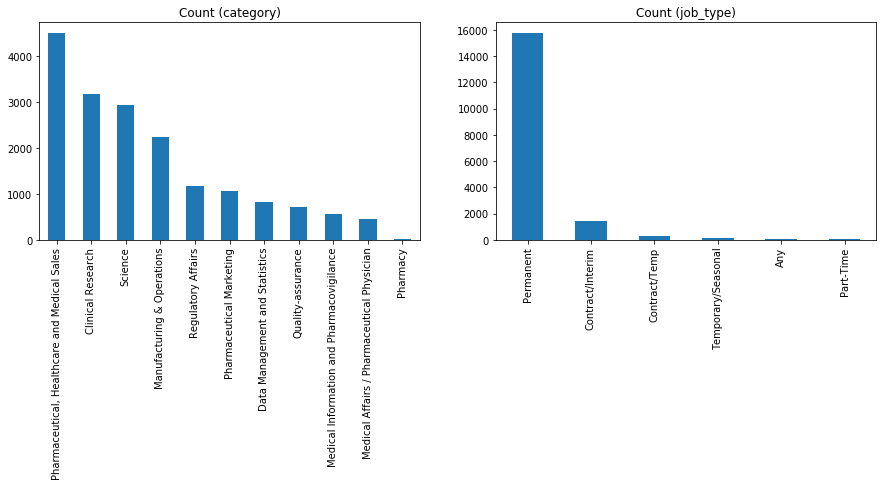

In [0]:
# Check class distribution
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
train.category.value_counts().plot(kind='bar', title='Count (category)', ax=ax1)
train.job_type.value_counts().plot(kind='bar', title='Count (job_type)', ax=ax2)

### Sampling: 
**Randome OverSampling**

In [0]:
counts_category = train.category.value_counts()
# Divide by class
df_class_Pharmacy = train[train['category'] == 'Pharmacy']
df_class_Mediacl_Affairs_Pharmaceutical_Phsician = train[train['category'] == 'Medical Affairs / Pharmaceutical Physician']
df_class_MedicalInformationandPharmacovigilance = train[train['category'] == 'Medical Information and Pharmacovigilance']
df_class_Qualityassurance = train[train['category'] == 'Quality-assurance']
df_class_DataManagementandStatistics = train[train['category'] == 'Data Management and Statistics']
df_class_PharmaceuticalMarketing = train[train['category'] == 'Pharmaceutical Marketing']
df_class_RegulatoryAffairs = train[train['category'] == 'Regulatory Affairs']
df_class_ManufacturingOperations = train[train['category'] == 'Manufacturing & Operations']
df_class_Science = train[train['category'] == 'Science']
df_class_ClinicalResearch = train[train['category'] == 'Clinical Research']
df_class_PharmaceuticalHealthcareMedicalSales = train[train['category'] == 'Pharmaceutical, Healthcare and Medical Sales']


In [0]:
# random oversampling
df_class_Pharmacy = df_class_Pharmacy.sample(counts_category[0], replace=True)
df_class_Mediacl_Affairs_Pharmaceutical_Phsician = df_class_Mediacl_Affairs_Pharmaceutical_Phsician.sample(counts_category[0], replace=True)
df_class_MedicalInformationandPharmacovigilance = df_class_MedicalInformationandPharmacovigilance.sample(counts_category[0], replace=True)
df_class_Qualityassurance = df_class_Qualityassurance.sample(counts_category[0], replace=True)
df_class_DataManagementandStatistics =df_class_DataManagementandStatistics.sample(counts_category[0], replace=True)
df_class_PharmaceuticalMarketing = df_class_PharmaceuticalMarketing.sample(counts_category[0], replace=True)
df_class_RegulatoryAffairs = df_class_RegulatoryAffairs.sample(counts_category[0], replace=True)
df_class_ManufacturingOperations = df_class_ManufacturingOperations.sample(counts_category[0], replace=True)
df_class_Science = df_class_Science.sample(counts_category[0], replace=True)
df_class_ClinicalResearch = df_class_ClinicalResearch.sample(counts_category[0], replace=True)


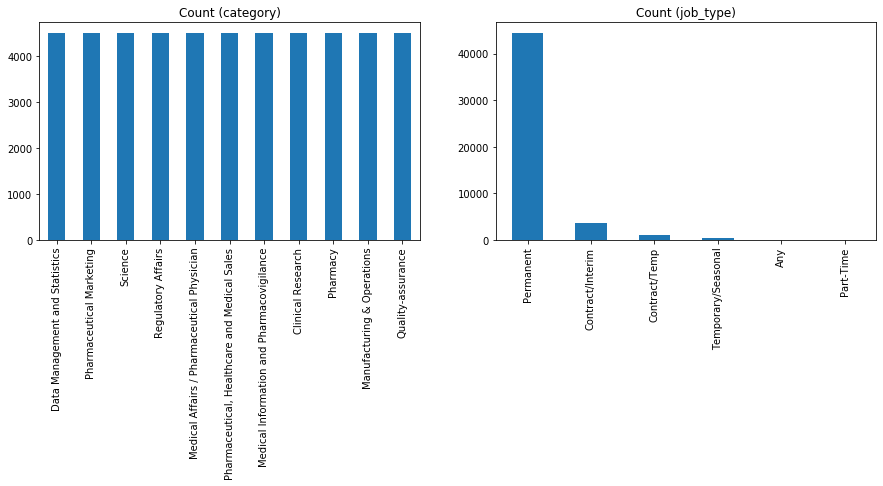

In [0]:
# concatenate individual datafram
df_train_oversampled = pd.concat([df_class_Pharmacy, df_class_Mediacl_Affairs_Pharmaceutical_Phsician, df_class_MedicalInformationandPharmacovigilance, df_class_Qualityassurance, df_class_DataManagementandStatistics, df_class_PharmaceuticalMarketing, df_class_RegulatoryAffairs, df_class_ManufacturingOperations, df_class_Science, df_class_ClinicalResearch, df_class_PharmaceuticalHealthcareMedicalSales], axis=0)

# Now, Check class distribution
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
df_train_oversampled.category.value_counts().plot(kind='bar', title='Count (category)', ax=ax1)
df_train_oversampled.job_type.value_counts().plot(kind='bar', title='Count (job_type)', ax=ax2)


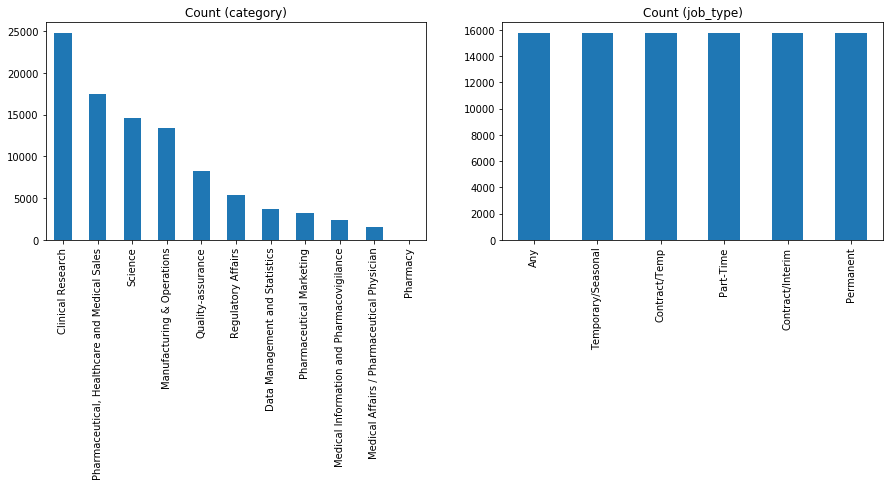

In [0]:
counts_job_type = train.job_type.value_counts()
# Divide by class
df_class_Permanent = train[train['job_type'] == 'Permanent']
df_class_Contract_Interim = train[train['job_type'] == 'Contract/Interim']
df_class_Contract_Temp = train[train['job_type'] == 'Contract/Temp']
df_class_Temprory_Seasonal = train[train['job_type'] == 'Temporary/Seasonal']
df_class_Any = train[train['job_type'] == 'Any']
df_class_Part_Time = train[train['job_type'] == 'Part-Time']

# random oversampling
df_class_Contract_Interim = df_class_Contract_Interim.sample(counts_job_type[0], replace=True)
df_class_Contract_Temp = df_class_Contract_Temp.sample(counts_job_type[0], replace=True)
df_class_Temprory_Seasonal = df_class_Temprory_Seasonal.sample(counts_job_type[0], replace=True)
df_class_Any = df_class_Any.sample(counts_job_type[0], replace=True)
df_class_Part_Time = df_class_Part_Time.sample(counts_job_type[0], replace=True)

df_train_oversampled_jobtype = pd.concat([df_class_Contract_Interim, df_class_Contract_Temp, df_class_Temprory_Seasonal, df_class_Any, df_class_Part_Time, df_class_Permanent], axis=0)

# Now, Check class distribution
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
df_train_oversampled_jobtype.category.value_counts().plot(kind='bar', title='Count (category)', ax=ax1)
df_train_oversampled_jobtype.job_type.value_counts().plot(kind='bar', title='Count (job_type)', ax=ax2)


### Model Building

In [0]:
# import model library
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
import xgboost as xgb
from sklearn.ensemble import VotingClassifier

# represent features in countvectorizer for job_type
vectorizer_1 = CountVectorizer()
vectorizer_1.fit(df_train_oversampled_jobtype.ngram_2)

# split into test and train sets for job_type
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_train_oversampled_jobtype.ngram_2, df_train_oversampled_jobtype.job_type, test_size=0.35)

# represent features in countvectorizer for category
vectorizer_2 = CountVectorizer()
vectorizer_2.fit(df_train_oversampled.ngram_2)

# split into test and train sets for job_type
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_train_oversampled.ngram_2, df_train_oversampled.category, test_size=0.35)


In [0]:
# Build LogisticRegression Model

lr_1 = LogisticRegression()
lr_1.fit(vectorizer_1.transform(X_train_1), y_train_1)
lr_2 = LogisticRegression()
lr_2.fit(vectorizer_2.transform(X_train_2), y_train_2)

print('Logistic Regression Score on Job Type: ', lr_1.score(vectorizer_1.transform(X_test_1), y_test_1))
print('Logistic Regression Score on Category: ', lr_2.score(vectorizer_2.transform(X_test_2), y_test_2))

y_1 = lr_1.predict(vectorizer_1.transform(X_test_1))
print("classification report on job type: ", classification_report(y_test_1, y_1))

y_2 = lr_2.predict(vectorizer_2.transform(X_test_2))
print("classification report on job category: ", classification_report(y_test_2, y_2))


# Build BernoulliNB Model
#bnb_1 = BernoulliNB()
#bnb_1.fit(vectorizer_1.transform(X_train_1), y_train_1)
#bnb_2 = BernoulliNB()
#bnb_2.fit(vectorizer_2.transform(X_train_2), y_train_2)

#print('Naive Bayes Score for Job Type: ', bnb_1.score(vectorizer_1.transform(X_test_1), y_test_1))
#print('Naive Bayes Score for Category: ', bnb_2.score(vectorizer.transform(X_test_2), y_test_2))

# Build XGboost Model
#xgb_model = xgb.XGBClassifier().fit(vectorizer.transform(X_train), y_train)

#print('XGBoost Score: ', xgb_model.score(vectorizer.transform(X_test), y_test))

Logistic Regression Score on Job Type:  0.9984908849450682
Logistic Regression Score on Category:  0.8106270170585523
classification report on job type:                      precision    recall  f1-score   support

               Any       1.00      1.00      1.00      5454
  Contract/Interim       0.99      1.00      1.00      5565
     Contract/Temp       1.00      1.00      1.00      5578
         Part-Time       1.00      1.00      1.00      5430
         Permanent       1.00      0.99      1.00      5494
Temporary/Seasonal       1.00      1.00      1.00      5611

          accuracy                           1.00     33132
         macro avg       1.00      1.00      1.00     33132
      weighted avg       1.00      1.00      1.00     33132

classification report on job category:                                                precision    recall  f1-score   support

                           Clinical Research       0.70      0.46      0.55      1591
              Data Management 

In [0]:
from sklearn.ensemble import VotingClassifier

#create submodels
estimators = []

model1 = lr
model2 = bnb
model3 = xgb_model


estimators.append(('logistic', model1))
estimators.append(('bernoulli', model2))
estimators.append(('xgboost', model3))


# create ensemble model for job type
ensemble_job_type = VotingClassifier(estimators).fit(vectorizer_1.transform(X_train_1), y_train_1)


# create ensemble model for Category
ensemble_category = VotingClassifier(estimators).fit(vectorizer_2.transform(X_train_2), y_train_2)


In [0]:
print('Ensemble Score for Job Type : ', ensemble_job_type.score(vectorizer_1.transform(X_test_1), y_test_1))
print('Ensemble Score for Category : ', ensemble_category.score(vectorizer_2.transform(X_test_2), y_test_2))

Ensemble Score for Job Type :  0.9941634755050839
Ensemble Score for Category :  0.7888154908980889


In [0]:
# preprocessing test data
test_corpus = text_preprocess(test.job_description)
ngram_phraser_1 = models.Phrases(test_corpus, threshold=1)
ngram_phraser_2 = models.Phrases(test_corpus, threshold=10)
ngram_1 = models.phrases.Phraser(ngram_phraser_1)
ngram_2 = models.phrases.Phraser(ngram_phraser_2)
test_texts_1 = [ngram_1[token] for token in test_corpus]
test_texts_2 = [ngram_2[token] for token in test_corpus]

test_texts_1 = [' '.join(text) for text in test_texts_1]
test_texts_2 = [' '.join(text) for text in test_texts_2]
test['ngram_1'] = test_texts_1
test['ngram_2'] = test_texts_2
test.head()

,job_no,job_description,ngram_1,ngram_2
0,Id-1,SAS Statistical Programmer II. UK. SDTM. ADaM....,sas_statistical programmer sdtm_adam tfls clin...,sas statistical_programmer sdtm_adam tfls clin...
1,Id-2,Therapy Area: Respiratory\r\r\r\nPackage: Nego...,therapy_area respiratory_package negotiable_ba...,therapy_area respiratory package_negotiable ba...
2,Id-4,RBW consulting are working in partnership with...,rbw_consult work_partnership specialist_biomet...,rbw_consult work partnership specialist_biomet...
3,Id-6,One of my long term clients is currently look...,long_term client_currently look_experience med...,long_term client currently_look experience med...
4,Id-7,Unique package - Statistical Programmer - CRO\...,unique_package statistical_programmer cro appr...,unique package statistical_programmer cro appr...


In [0]:
#ensemble on test data
ensemble_job_type.fit(vectorizer_1.transform(df_train_oversampled_jobtype.ngram_1), df_train_oversampled_jobtype.job_type)
prediction_1 = ensemble_job_type.predict(vectorizer_1.transform(test.ngram_1))

ensemble_category.fit(vectorizer_2.transform(df_train_oversampled.ngram_1), df_train_oversampled.category)
prediction_2 = ensemble_category.predict(vectorizer_2.transform(test.ngram_1))

submission = pd.DataFrame({'job_no':test.job_no, 'job_type':prediction_1, 'category':prediction_2})
submission.to_csv('sample_submission.csv', index=False)
submission.head()

In [0]:
submission.head()

,job_no,job_type,category
0,Id-1,Permanent,Data Management and Statistics
1,Id-2,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
2,Id-4,Permanent,Data Management and Statistics
3,Id-6,Permanent,Pharmaceutical Marketing
4,Id-7,Permanent,Clinical Research


In [0]:
#logistic on test data
lr_1.fit(vectorizer_1.transform(df_train_oversampled_jobtype.ngram_2), df_train_oversampled_jobtype.job_type)
prediction_1 = lr_1.predict(vectorizer_1.transform(test.ngram_2))

lr_2.fit(vectorizer_2.transform(df_train_oversampled.ngram_2), df_train_oversampled.category)
prediction_2 = lr_2.predict(vectorizer_2.transform(test.ngram_2))

submission = pd.DataFrame({'job_no':test.job_no, 'job_type':prediction_1, 'category':prediction_2})
submission.to_csv('sample_submission_lr_3rd.csv', index=False)
submission.head()

,job_no,job_type,category
0,Id-1,Permanent,Data Management and Statistics
1,Id-2,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
2,Id-4,Permanent,Data Management and Statistics
3,Id-6,Permanent,Pharmaceutical Marketing
4,Id-7,Permanent,Data Management and Statistics
